In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="ticks",font="times",font_scale=1.4)
import astropy.coordinates as coord
import astropy.units as u

#### GREX-PLUSサーベイによるY-dwarf発見の副産物
GREX-PLUSの広視野撮像サーベイ(全天の約1/40)で、WISEで検出されたような低温褐色矮星($\leq500$K)が多分検出される。<br>
以下、Y-dwarfの雑なyield estimateを行う。使ったカタログは以下。<br>
https://ui.adsabs.harvard.edu/abs/2021ApJS..253....7K/abstract

In [42]:
df = pd.read_csv("./Kirkpatrick2021.tsv",comment="#",sep=";").drop(index=[0,1]).reset_index(drop=True)
var_lst = ["Teff","e_Teff","_RA","_DE","plx"]
LD = df[df['SpTIR'].str.contains('L')].reset_index(drop=True)
TD = df[df['SpTIR'].str.contains('T')].reset_index(drop=True)
YD = df[df['SpTIR'].str.contains('Y')].reset_index(drop=True)
TD[var_lst] = TD[var_lst].astype(float) 
YD[var_lst] = YD[var_lst].astype(float) 

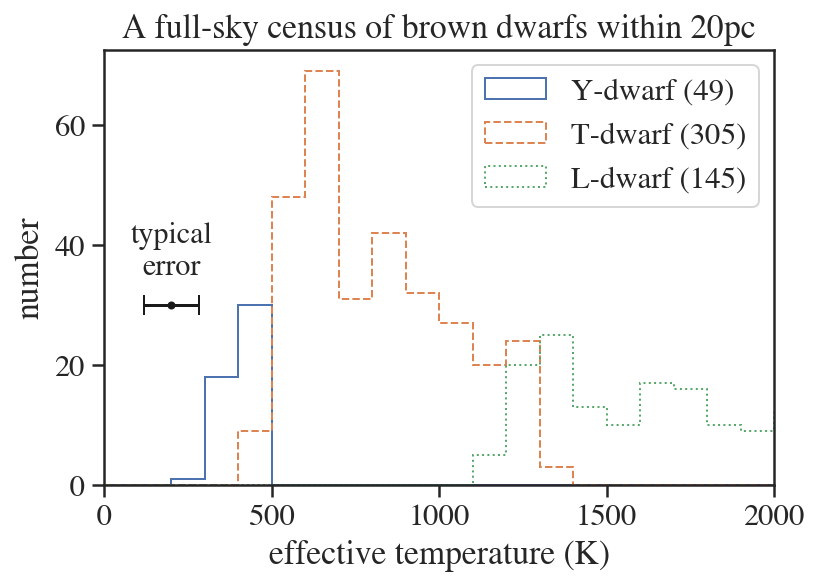

In [43]:
bins=np.arange(0,2500,100)
plt.hist(np.array(YD.Teff.values,dtype="float"),bins=bins,histtype="step",label="Y-dwarf (%d)"%(len(YD)),ls="-")
plt.hist(np.array(TD.Teff.values,dtype="float"),bins=bins,histtype="step",label="T-dwarf (%d)"%(len(TD)),ls="--")
plt.hist(np.array(LD.Teff.values,dtype="float"),bins=bins,histtype="step",label="L-dwarf (%d)"%(len(LD)),ls=":")
plt.xlabel("effective temperature (K)")
plt.ylabel("number")
plt.errorbar(200,30,xerr=np.mean(YD.e_Teff),c="k",capsize=5,fmt=".")
plt.text(200,35,"typical\nerror",fontsize=15,horizontalalignment="center")
plt.xlim(0,2000)
plt.legend()
plt.title("A full-sky census of brown dwarfs within 20pc")
plt.show()

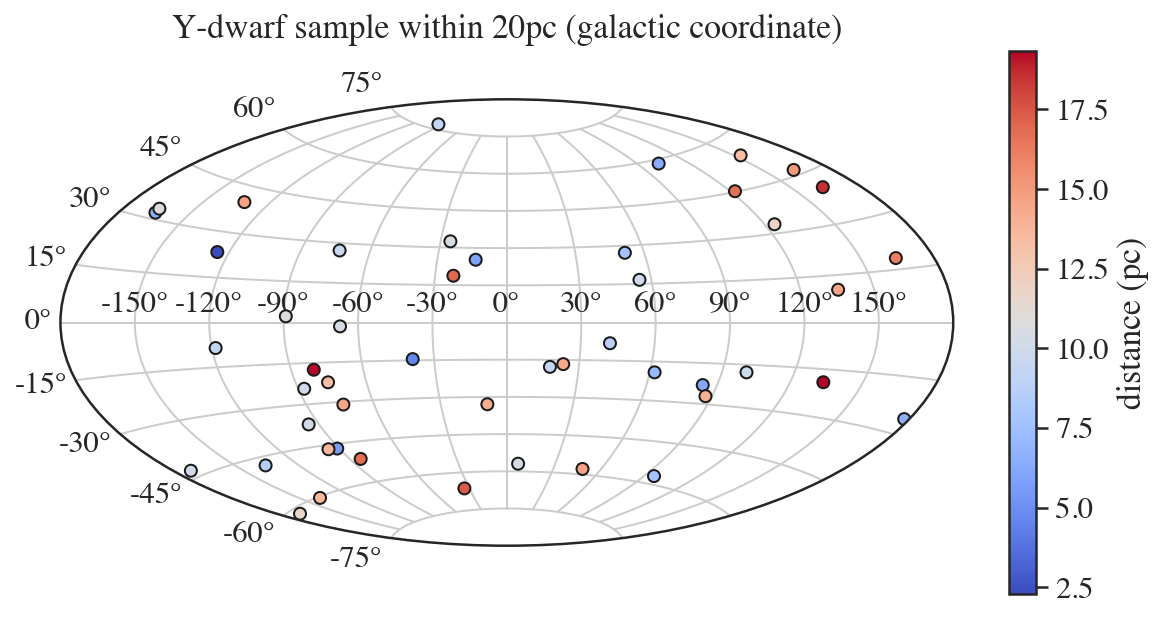

In [44]:
fig=plt.figure(figsize=(10,5))
plt.subplot(111, projection='aitoff')
plt.grid(True)
YD_icrs = coord.SkyCoord(ra=YD._RA,dec=YD._DE,unit=u.deg)
YD_gal = YD_icrs.galactic
plt.scatter(YD_gal.l.wrap_at('180d').radian, YD_gal.b.radian,ec="k",
            c=1000./np.array(YD.plx,dtype="float"),cmap="coolwarm")
cb = plt.colorbar()
cb.set_label("distance (pc)")
plt.title("Y-dwarf sample within 20pc (galactic coordinate)",pad=30.5)
plt.show()

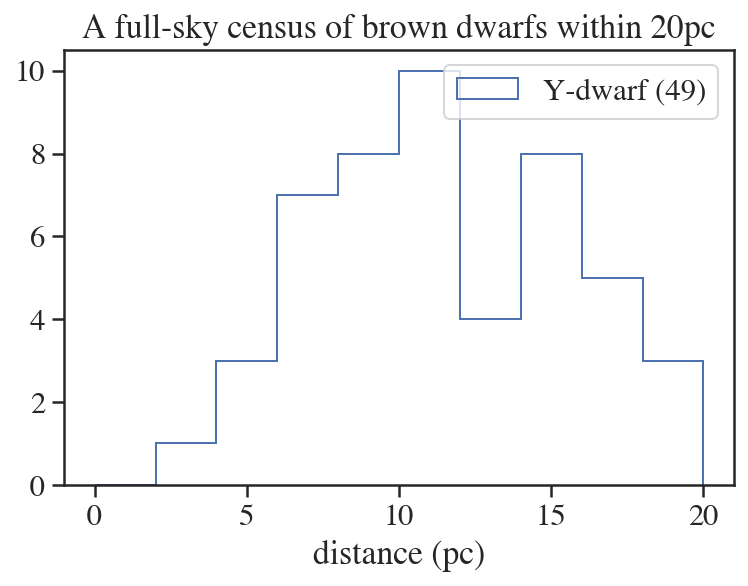

In [45]:
bins=np.arange(0,22,2)
plt.hist(1000./np.array(YD.plx,dtype="float"),histtype="step",label="Y-dwarf (%d)"%(len(YD)),bins=bins)
plt.xlabel("distance (pc)")
plt.legend()
plt.title("A full-sky census of brown dwarfs within 20pc")
plt.show()

##### WISE
- diameter 40cm
- 3.4, 4.6, 12 and 22 μm wavelength range bands
- 地球極軌道で約半年で全天を一回撮像するらしい。観測頻度2/yearの光度曲線を得る
##### GREX-PLUS
- diameter 1.2m
- 2-5ミクロン帯：3バンド、5-10ミクロン帯：3バンド
- 高分散分光器(10-20ミクロン帯)、R=30,000 (Δv=10 km/s)
- 観測戦略は
##### 雑推定 (WISEが発見したY-dwarfサンプル)
- Y-dwarf分布は空間的に一様、年齢依存性も無視。
- 口径比は(1.2m/0.4m)=3倍
- GREX-PLUXのサーベイ領域は全天の$1/40$
- 探査できる距離$d$は、$Flux\propto1/d^2$なので、$d \propto SNR$
- $SNR=10$とすると、GREX-PLUXが探査できるvolumeはWISEの$10^3/40=25$倍
- GREX-PLUXが発見する(WISEが見つけたような)Y-dwarfサンプルは$49\times25=1225$個

Assuming SNR=18.73, the Y-dwarf yield by GREX would be 8043.51


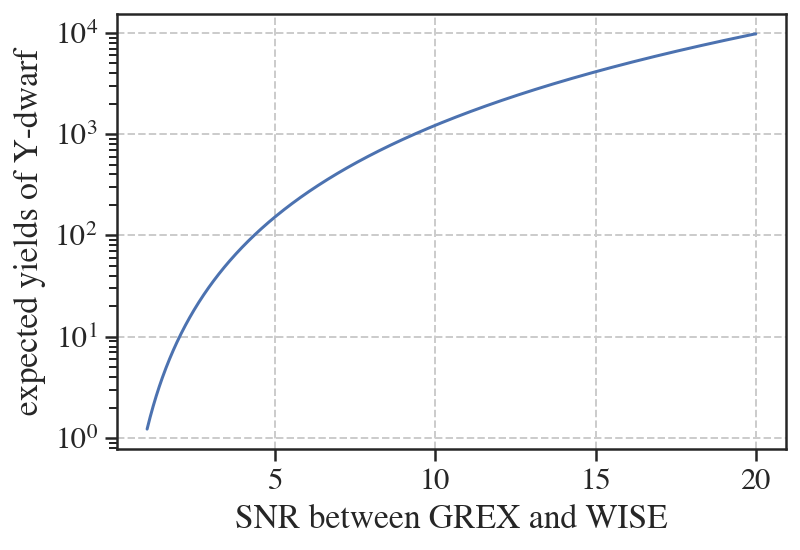

In [46]:
diameter_WISE = 0.4 #[m]
diameter_GREX = 1.2 #[m]
exposure_WISE = 7.7 #[sec]
exposure_GREX = 300 #[sec]
yield_YD_WISE = 49
ratio_Survey_Field = 1./40. 

aperture_ratio = (diameter_GREX/diameter_WISE)**2
exposure_ratio = exposure_GREX/exposure_WISE
SNR = np.sqrt(aperture_ratio*exposure_ratio)
volume_ratio = SNR**3 * ratio_Survey_Field
yield_GREX = yield_YD_WISE * volume_ratio
print("Assuming SNR=%.2f, the Y-dwarf yield by GREX would be %.2f"%(SNR,yield_GREX))

SNR_arr = np.linspace(1,20,1000)
plt.plot(SNR_arr,SNR_arr**3 * ratio_Survey_Field * yield_YD_WISE)
plt.xlabel("SNR between GREX and WISE")
plt.ylabel("expected yields of Y-dwarf")
plt.yscale("log")
plt.grid(ls="--")
plt.show()

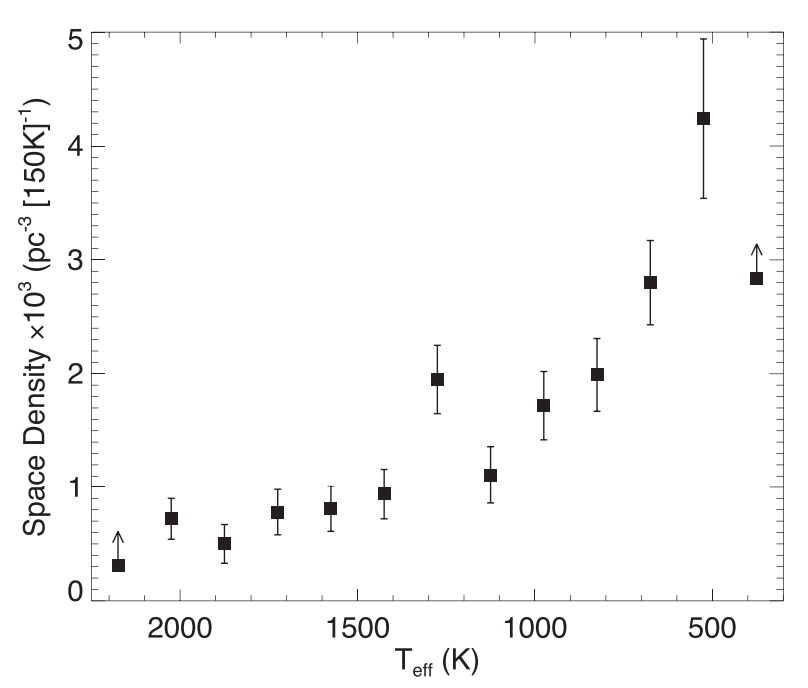

In [47]:
from IPython.display import Image
Image("./teff_func.png",width=300)

##### WISEで見えていなかった、より軽い褐色矮星・惑星質量天体
口径が大きくなることで、より低質量の天体が受かるかも
https://ui.adsabs.harvard.edu/abs/2021ApJS..253....7K/abstract　<br>
に数密度分布が推定されていたが、これはcompletenessが考慮されている。<br>
適当に外挿すると、
- $\sim6\times10^{-3} \mathrm{pc}^{-3} [150K]^{-1}$@450-300K
- $\sim1\times10^{-2} \mathrm{pc}^{-3} [150K]^{-1}$@300-150K <br>

In [55]:
occ_300K = 6e-3
occ_150K = 1e-2

distant_YD = YD.sort_values("plx").reset_index(drop=True)
teff_yd = YD.Teff.values
distance_yd = 1000./YD.plx.values
dark_YD = YD.iloc[np.argmin(teff_yd**4/distance_yd**2)]
print("faintest in 20pc:T=",dark_YD.Teff,"(K), distance=",1000/dark_YD.plx," (pc)")

faintest in 20pc:T= 377.0 (K), distance= 19.25513438158285  (pc)


有効温度と距離で一番暗いY-dwarfは~20pcで377K。これを検出限界とすると、同じS/Nで300K、150Kの天体が受かる距離は、

In [61]:
dteff = dark_YD.Teff
ddist = 1000/dark_YD.plx
dist_300K = np.sqrt(ddist**2*300**4/dteff**4)
dist_150K = np.sqrt(ddist**2*150**4/dteff**4)
print("distance 300K: %.2f pc"%(dist_300K))
print("distance 150K: %.2f pc"%(dist_150K))

distance 300K: 12.19 pc
distance 150K: 3.05 pc


magnitude limitサンプルで、この距離以遠は急激に検出効率が落ちると仮定する。<br>
ただ、この距離内ではcompletenessが100\%とすると、space densityから期待されるWISEで発見するY-dwarfの数は

In [64]:
yields_300K = 4/3*np.pi*dist_300K**3 * occ_300K
yields_150K = 4/3*np.pi*dist_150K**3 * occ_150K
print("300K-450K:%.2f "%yields_300K)
print("150K-300K:%.2f "%yields_150K)

300K-450K:45.56 
150K-300K:1.19 


実際、WISEで$T>300K$のY-dwarfが50個くらい受かっているので、オーダーでは合ってると思う。<br>
GREXでは、

In [65]:
SNR_assume = 10
yields_150K_GREX = 4/3*np.pi*(dist_150K*SNR_assume)**3 * occ_150K * ratio_Survey_Field
print("150K-300K:%.2f "%yields_150K_GREX)

150K-300K:29.66 
